In [2]:
import scipy.io
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

from utils import ImageLoader, plot_dataset_spiral, spiral_coords

%load_ext autoreload
%autoreload 2

plt.rcParams.update(
    {
        "font.size": 14,
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": "Computer Modern Roman",
    }
)

In [55]:
# Chai Experiment Parameters
upsampRatio = 4  # upsampling ratio
mag = 1.95
pixelSize = 4.8e-6/mag  # low-res pixel size of the camera sensor
NA = 0.10
wavelength = 0.635e-6  # 630nm LED light
# wavelength = 0.627e-6  # 630nm LED light
# wavelength = 0.523e-6  # 630nm LED light
# wavelength = 0.467e-6  # 630nm LED light

# 7x7
LEDsize = 7            # size of the LED array (assumed to be odd)
LEDgap = 4.0              # distance between LED elements (in mm)
# LEDheight = 80.0  # vertical distance between LED array and specimen (in mm)
LEDheight = 45.0  # updated
# LEDheight = 60.0  # updated

# 7x7 P2
# LEDsize = 7  # size of the LED array (assumed to be odd)
# LEDgap = 2.0  # distance between LED elements (in mm)
# LEDheight = 38.1  # vertical distance between LED array and specimen (in mm)

# 15x15 P2
# LEDsize = 15  # size of the LED array (assumed to be odd)
# LEDgap = 2.0  # distance between LED elements (in mm)
# LEDheight = 66.73  # vertical distance between LED array and specimen (in mm)

# Image Parameters
ml = nl = 256
m = n = ml * upsampRatio

# Sampling in Spatial Domain

Pixel Aliasing Problem

If $R_{cam} = \frac{f_{cam}}{f_{obj}} < 1$ aliasing would occur


In [56]:
fCAM = np.pi / pixelSize
# fCAM = mag * np.pi / pixelSize  # with magnification
fOBJ = NA * (2 * np.pi / wavelength)

print(f"f_CAM = {fCAM:.0f}")
print(f"f_OBJ = {fOBJ:.0f}")

RCAM = fCAM / fOBJ
print(f"R_CAM = {RCAM}")

f_CAM = 1276272
f_OBJ = 989478
R_CAM = 1.28984375


Text(0.5, 1.0, 'CTF (635 nm), $Rcam=1.29$')

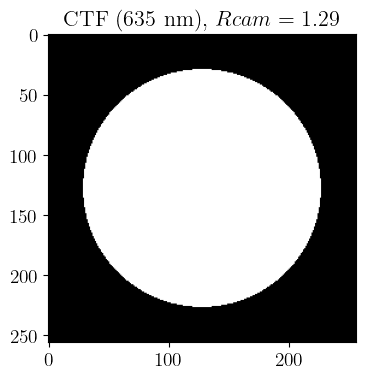

In [57]:
k0 = 2 * np.pi / wavelength

# Generate Low-pass filter Coherent Transfer Function
dkx = 2 * np.pi / (pixelSize * nl)
dky = 2 * np.pi / (pixelSize * ml)

cutoffFrequency = NA * k0
kmax = np.pi / pixelSize
XX = np.linspace(-kmax, kmax, int(nl))
YY = np.linspace(-kmax, kmax, int(ml))

kxm, kym = np.meshgrid(XX, YY)

CTF = (kxm**2 + kym**2) < cutoffFrequency**2  # Coherent Transfer Function
plt.figure(figsize=(4, 4))
plt.imshow(CTF, cmap="gray")
plt.title(f"CTF (635 nm), $Rcam={RCAM:.2f}$", fontsize=16)
# plt.colorbar()
# plt.savefig("Sampling reqs/CTF-635.png", dpi=300, bbox_inches="tight", pad_inches=0)

In [58]:
np.min(kxl)
np.min(kxc)
# cutoffFrequency/dkx

318.0

# Sampling in Frequency Space


R_LED = 1.1294356998076516
R_Overlap = 42.26%


Text(0.5, 1.0, 'Fourier Space, Roverlap=42.26\\%')

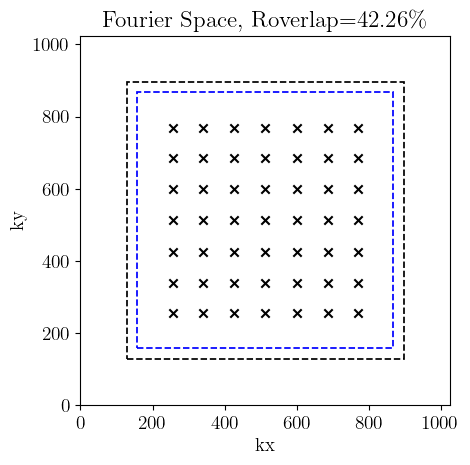

In [59]:
# Calculate wavevectors
xloc, yloc = spiral_coords(0, 0, LEDsize)
kxRel = -np.sin(np.arctan(xloc * LEDgap / LEDheight))
kyRel = -np.sin(np.arctan(yloc * LEDgap / LEDheight))
k0 = 2 * np.pi / wavelength
kx = k0 * kxRel
ky = k0 * kyRel

dkx = 2 * np.pi / (pixelSize * nl)
dky = 2 * np.pi / (pixelSize * ml)

# Calculate fourier shift
kxc = np.round((n + 1) / 2 + kx / dkx)
kyc = np.round((m + 1) / 2 - ky / dky)

kyl = np.round(kyc - (ml / 2))
kyh = np.round(kyc + (ml / 2))
kxl = np.round(kxc - (nl / 2))
kxh = np.round(kxc + (nl / 2))

# Fourier Overlap Calculation
fOBJ = NA * k0
fLED = np.abs(kx[1])
RLED = fOBJ / fLED
print(f"R_LED = {RLED}")


ROverlap = (
    (2 * np.arccos(1 / (2 * RLED)) - np.sqrt(1 - (1 / (2 * RLED)) ** 2)) / np.pi
    if RLED > 0.5
    else 0
)
print(f"R_Overlap = {ROverlap*100:.2f}%")

# Display Fourier Sampling

fig, ax = plt.subplots()

corner = np.min(kxc)-(cutoffFrequency/dkx)
width = (np.max(kxc) - np.min(kxc)) + (2*cutoffFrequency/dkx)
ax.add_patch(Rectangle((corner, corner), width,
                       width,
                       edgecolor='blue',
                       facecolor='none',
                       fill=False,
                       linestyle='dashed',
                       linewidth=1.25))

width = (np.max(kxl) - np.min(kxl)) + ml
ax.add_patch(Rectangle((np.min(kxl), np.min(kyl)), width,
                       width,
                       edgecolor='black',
                       facecolor='none',
                       fill=False,
                       linestyle='dashed',
                       linewidth=1.25))

ax.scatter(kxc, kyc, marker="x", color="black")
ax.set_aspect("equal")
ax.set_xlim(0, m)
ax.set_ylim(0, n)
ax.set_xlabel("kx")
ax.set_ylabel("ky")
ax.set_title(f"Fourier Space, Roverlap={ROverlap*100:.2f}\%")
# plt.savefig("Sampling reqs/spectrum-15x15panel.png", dpi=300, bbox_inches="tight", pad_inches=0)

In [43]:
kx / dkx

array([  -0.        , -150.6838912 , -150.6838912 ,   -0.        ,
        150.6838912 ,  150.6838912 ,  150.6838912 ,   -0.        ,
       -150.6838912 , -299.90718681, -299.90718681, -299.90718681,
       -299.90718681, -150.6838912 ,   -0.        ,  150.6838912 ,
        299.90718681,  299.90718681,  299.90718681,  299.90718681,
        299.90718681,  150.6838912 ,   -0.        , -150.6838912 ,
       -299.90718681, -446.27902912, -446.27902912, -446.27902912,
       -446.27902912, -446.27902912, -446.27902912, -299.90718681,
       -150.6838912 ,   -0.        ,  150.6838912 ,  299.90718681,
        446.27902912,  446.27902912,  446.27902912,  446.27902912,
        446.27902912,  446.27902912,  446.27902912,  299.90718681,
        150.6838912 ,   -0.        , -150.6838912 , -299.90718681,
       -446.27902912, -588.54042809, -588.54042809, -588.54042809,
       -588.54042809, -588.54042809, -588.54042809, -588.54042809,
       -588.54042809, -446.27902912, -299.90718681, -150.68389

(0.0, 1024.0)

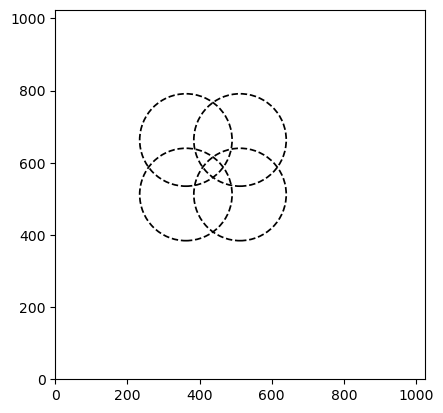

In [96]:
fig, ax = plt.subplots()

for i in range(4):

    # for i in range(LEDsize**2):
    ax.add_patch(
        Circle(
            (kxc[i], kyc[i]),
            radius=ml / 2,
            edgecolor="black",
            facecolor="none",
            linestyle="dashed",
            linewidth=1.25,
        )
    )

# for i in range(LEDsize**2):
#     ax.add_patch(Rectangle((kxl[i], kyl[i]), ml, nl,
#                            edgecolor='black',
#                            facecolor='none',
#                            fill=False,
#                            linestyle='dashed',
#                            linewidth=1.25))

ax.set_aspect("equal")
ax.set_xlim(0, m)
ax.set_ylim(0, n)